<a href="https://colab.research.google.com/github/GBS22HG/HUGO_GRIFO_PUC_RIO_POS/blob/main/MVP_Machine_Learning_and_Analytics_Hugo_Grifo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**MVP Machine Learning & *Analytics***

**Autor**: Hugo Henrique Barreiros Grifo

**Data**: 28/09/2025

**Matrícula**: 4052025000244

**Dataset**: Student Performance Dataset (Fonte: UCI Machine Learning Repository)

#1. Escopo, objetivo e definição do problema

**Escopo**: O conjunto de dados "Student Perfomance", é um conjunto de dados multivariado que contém as notas dos estudantes secundaristas de 2 escolas portuguesas ("Gabriel Pereira" e "Mousinho da Silveira") nas 3 avaliações de conteúdo da disciplina de Português, realizadas pelos estudantes ao curso de um ano letivo (não informado o período do dataset).

**Objetivo**: Correlacionar as informações pessoais, familiares e sócio-econômicas disponíveis no conjunto de dados, com o desempenho em avaliações de conteúdo dos estudantes e, construir modelos de **Regressão** capazes de prever a nota final dos alunos utilizando esses atributos como variáveis indepentes.

*Hipótese 1: Alunos do sexo feminino tem maior probabilidade de terem um bom desempenho escolar?*

*Hipótese 2: Temos uma acurácia maior ou menor quando utilizamos as notas das avaliçaões anteriores a final no modelo?*

**Tipo de tarefa**: Problema de Regressão

**Área de aplicação**: Dados tabulares, Educação.

#2. Reprodutibilidade e ambiente

In [264]:
# Filtrando Warnings do Notebook
import warnings
warnings.filterwarnings('ignore')

In [265]:
# Instalações no Ambiente
!pip install mord

# Bibliotecas e Parâmetros
import os, random, time, sys, math
import numpy             as np
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt
import statsmodels.api   as sm #API para modelos estatísticos GLM
import mord # Biblioteca para Regressão Ordinal
import pickle

# Módulos e Funções
from sklearn.model_selection   import train_test_split, cross_val_score, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.compose           import ColumnTransformer
from sklearn.preprocessing     import OneHotEncoder, StandardScaler
from sklearn.impute            import SimpleImputer
from sklearn.pipeline          import Pipeline
from sklearn.dummy             import DummyRegressor
from sklearn.linear_model      import LinearRegression, Ridge, Lasso
from sklearn.ensemble          import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree              import DecisionTreeRegressor
from sklearn.base              import BaseEstimator, RegressorMixin
from sklearn.metrics           import (accuracy_score, f1_score, roc_auc_score, confusion_matrix,
                                     mean_absolute_error, mean_squared_error, r2_score, silhouette_score)
from sklearn.feature_selection import SelectKBest, f_regression
from scipy.stats               import randint, uniform

# Amostragem
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Informações do Ambiente
print("Python:", sys.version.split()[0])
print("Seed global:", SEED)

Python: 3.12.11
Seed global: 42


#2.2 Funções python

Nesse bloco, iremos definir todas as funções não nativas que serão aplicadas na construção dos modelos

In [266]:
#Função para Avaliar Métricas de Desempenho da Regressão:
def evaluate_regression(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R²": r2}


# Função para habilitar novos tipos de Regressão (Ordinal, Binomial, Poisson)

class StatsmodelsWrapper(BaseEstimator, RegressorMixin):
    """ Um wrapper para usar modelos GLM do statsmodels como estimadores do scikit-learn. """
    def __init__(self, model_class):
        self.model_class = model_class
        self.model_ = None

    def fit(self, X, y):
        # statsmodels precisa de uma coluna de intercepto (constante)
        X_const = sm.add_constant(X)
        self.model_ = self.model_class(y, X_const).fit()
        return self

    def predict(self, X):
        # Adiciona a constante também nos dados de teste
        X_const = sm.add_constant(X, has_constant='add')
        predictions = self.model_.predict(X_const)

        # Arredonda e garante que as previsões estejam no intervalo [0, 20]
        return np.round(predictions.clip(0, 20))


# Função auxiliar para extrair um DataFrame de coeficientes de um modelo

def coef_modelo_df(pipeline, preprocessor_step_name, model_step_name, selector_step_name=None):
    """
    Função final para extrair coeficientes de um pipeline, com nomes de etapas customizáveis.

    Args:
        pipeline: O pipeline treinado.
        preprocessor_step_name (str): O nome da etapa de pré-processamento.
        model_step_name (str): O nome da etapa do modelo.
        selector_step_name (str, opcional): O nome da etapa de seleção de features.
    """
    # Acessa as etapas do pipeline pelos nomes fornecidos
    preprocessor = pipeline.named_steps[preprocessor_step_name]
    model = pipeline.named_steps[model_step_name]

    all_feature_names = preprocessor.get_feature_names_out()

    # Se um nome para a etapa de seleção for fornecido, usa-o para filtrar as features
    if selector_step_name and selector_step_name in pipeline.named_steps:
        selector = pipeline.named_steps[selector_step_name]
        mask = selector.get_support()
        final_feature_names = all_feature_names[mask]
    else:
        final_feature_names = all_feature_names

    # Pega os coeficientes ou a importância das features
    if hasattr(model, 'coef_'):
        coefficients = model.coef_.flatten()
    elif hasattr(model, 'feature_importances_'):
        coefficients = model.feature_importances_
    else:
        return pd.DataFrame()

    return pd.DataFrame({
        'Feature': final_feature_names,
        'Beta': coefficients
    })

#3. Dados: carga, entendimento e qualidade

O dataset "Students Performance" é um conjunto de dados disponível gratuitamente pelo site oficial da "UC Irvine - Machine Learning Repository" (url: https://archive.ics.uci.edu/dataset/320/student+performance) .

Não é necessária uma etapa de seleção de dados externa, pois o dataset já está curado e pronto para uso. O documento oficial é repartido em 2 conjuntos de dados segmentados pelas disciplinas de "Matemática" e "Português" contudo, nesse projeto não temos interesse em analisar a diferença no desempenho entre as disciplinas e portanto, para não viesar os dados de treino, utilizaremos apenas a base de "Português".

#3.1 Dicionário de Variáveis
O dataset "Student Perfomance" contém 649 instâncias e possui 33 atributos:

*Observação: O dataset se encontra no idioma inglês- EUA e os dados se tratam de estudantes  portugueses- PT. Portanto, podem haver pequenos desvios na tradução dos atributos.*

- **school** - Escola do estudante (binária: "GP" - Gabriel Pereira ou "MS" - Mousinho da Silveira)
- **sex** - student's sex (binário: "F" - Mulher ou "M" - Homem)
- **age** - Idade (numérico: de 15 a 22)
- **address** - Tipo de endereço (binário: "U" - Urbano ou "R" - Rural)
- **famsize** - Tamanho da família (binário: "LE3" - Menor ou igual a 3 pessoas ou "GT3" - Maior que 3 pessoas)
- **Pstatus** - Cohabitação dos pais (binário: "T" - Moram juntos ou "A" - Separados)
- **Medu** - Nível educacional da Mãe (numérico: 0 - Nenhum,  1 - Nível Fundamental 1 (5º Ano), 2 – Nível Fundamentel 2 (9º Ano), 3 – Ensino Médio  ou 4 – Ensino Superior)
- **Fedu** - Nível educacional do Pai (numérico: 0 - Nenhum,  1 - Nível Fundamental 1 (5º Ano), 2 – Nível Fundamentel 2 (9º Ano), 3 – Ensino Médio  ou 4 – Ensino Superior)
- **Mjob** - Profissão da Mãe (categórico: "teacher" (professora), "health" care related (profissional da saúde), civil "services" (e.g. administrativo ou policial), "at_home" (doméstica) ou "other" (outro))
- **Fjob** - Profissão do Pai (categórico: "teacher" (professor), "health" care related (profissional da saúde), civil "services" (e.g. administrativo ou policial), "at_home" (doméstico) ou "other" (outro))
- **reason** - Motivo de estudar na escola (categórico: close to "home" (proximidade), school "reputation" (reputação da escola), "course" preference (preferência do currículo) ou "other" (outro))
- **guardian** - Responsável do estudante (categórico: "mother"(mãe), "father" (pai) ou "other" (outro))
- **traveltime** - Tempo de deslocamento de casa para a escola (numérico: 1 - até 15 min., 2 - 15 a 30 min., 3 - 30 min. a 1 hora, ou 4 - mais de 1 hora)
- **studytime** - Tempo de estudos por semana (numérico: 1 - até 2 horas, 2 - 2 a 5 horas, 3 - 5 a 10 horas, ou 4 - mais de 10 horas)
-  **failures** - Quantidade de reprovações passadas (numérico: n para 1 <= n < 3, 4 para mais que 4)
- **schoolsup** - Apoio escolar extra (binário: yes (sim) ou no (não))
- **famsup** - Apoio educacional familiar (binário: yes (sim) ou no (não))
-  **paid** - Reforço escolar pago na disciplina (binário: yes (sim) ou no (não))
- **activities** - Atividades extra-curriculares (binário: yes (sim) ou no (não))
- **nursery** - Frequentou creche na infância (binário: yes (sim) ou no (não))
- **higher** - Pretende fazer faculdade (binário: yes (sim) ou no (não))
- **internet** - Possui acesso a internet em casa (binário: yes (sim) ou no (não))
- **romantic** - Está em um relacionamento amoroso (binário: yes (sim) ou no (não))
-**famrel** - Qualidade do relacionamento familiar (numérico: de 1 - muito ruim a 5 - excelente)
- **freetime** - Tempo livre após a escola (numérico: de 1 - muito baixo a 5 - muito alto)
- **goout** - Frequência de saídas com os amigos (numérico: de 1 - muito baixo a 5 - muito alto)
- **Dalc** - Consumo de álcool durante a semana (numérico: de 1 - muito baixo a 5 - muito alto)
- **Walc** - Consumo de álcool durante o final de semana (numérico: de 1 - muito baixo a 5 - muito alto)
- **health** - Status atual de saúde (numérico: de 1 - muito ruim a 5 - muito bom)
- **absences** - Quantidade de faltas no ano letivo (numério: de 0 a 93)

Essas varíaveis, são relacionadas as notas das avaliações do ano letivo:

- **G1** - Nota da avaliação de conteúdo da disciplina do primeiro período do ano letivo (numérico: de 0 a 20)
- **G2** - Nota da avaliação de conteúdo da disciplina do segundo período do ano letivo (numérico: de 0 a 20)
- **G3** - Nota final da disciplina no ano letivo (numérico: de 0 a 20, **VARIÁVEL ALVO**)

#3.2 Carga dos Dados

In [267]:
# Importanto os dados pelo meu repositório do GitHub
url_port = 'https://raw.githubusercontent.com/GBS22HG/HUGO_GRIFO_PUC_RIO_POS/main/student-por.csv' # base de português

In [268]:
# Criando 1 Datrame para o dataset (base de portguês)
df = pd.read_csv(url_port, delimiter=';')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


#3.3 Análise exploratória resumida (EDA)

O mesmo dataset foi utilizado no MVP da disciplina "Análise de Dados e Boas Práticas" e pode ser acessado com mais detalhes no link: https://colab.research.google.com/drive/1SU8EMmOjNnkiigojlVgb3cu61jFQ7DpP#scrollTo=65fdlKvq2Jbk

In [269]:
# Levantamento de informações sobre cada atributo #
print(f"Total de instâncias: {len(df)}")
print("\nTipos de dados por coluna:")
print(df.info())

Total de instâncias: 649

Tipos de dados por coluna:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 1

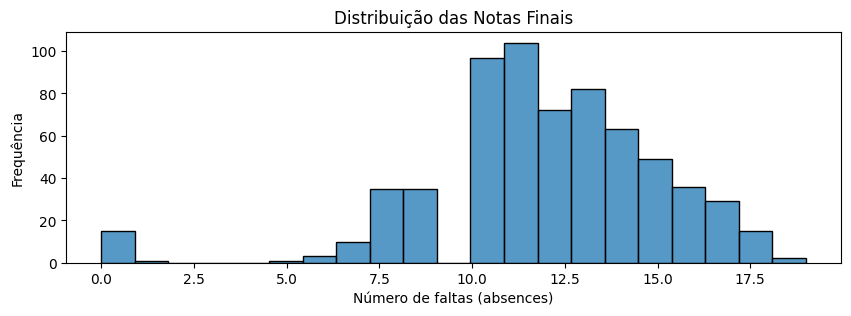

In [270]:
# Histograma das notas finais (G3)
plt.figure(figsize=(10, 3))
sns.histplot(df['G3'], kde=False)
plt.title('Distribuição das Notas Finais')
plt.xlabel('Número de faltas (absences)')
plt.ylabel('Frequência')
plt.show()


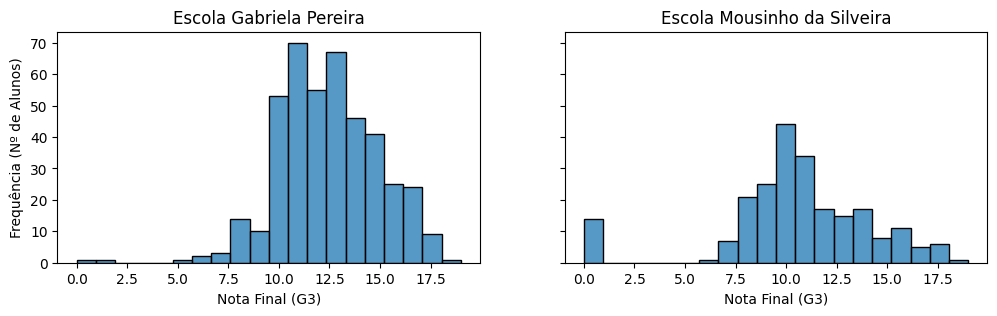

In [271]:
# Histograma de notas para cada uma das 2 escolas

#Filtrar os dados para cada escola
df_escola_GP = df[df['school'] == 'GP']
df_escola_MS = df[df['school'] == 'MS']

# Setando 2 Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=True)

# Escola Gabriela Pereira
sns.histplot(df_escola_GP['G3'], kde=False, bins=20, ax=axes[0])
axes[0].set_title(f'Escola Gabriela Pereira')
axes[0].set_xlabel('Nota Final (G3)')
axes[0].set_ylabel('Frequência (Nº de Alunos)')


# Escola Mousinho da Silveira
sns.histplot(df_escola_MS['G3'], kde=False, bins=20, ax=axes[1])
axes[1].set_title(f'Escola Mousinho da Silveira')
axes[1].set_xlabel('Nota Final (G3)')
axes[1].set_ylabel('Frequência (Nº de Alunos)')


# Ajusta o layout para evitar sobreposição de títulos e eixos
plt.tight_layout(rect=[0, 1, 2, 0.96]) # Ajusta o rect para dar espaço ao suptitle
plt.show()


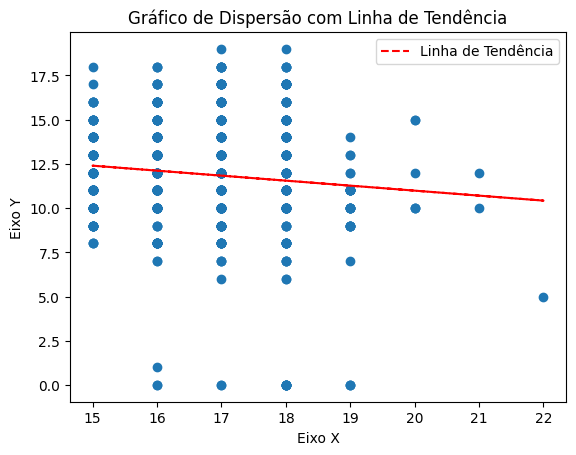

In [272]:
# Gráfico de dispersão de Notas por Idade

# Gráfico de dispersão
plt.scatter(df['age'],df['G3'])

# Criando uma linha de tendência de (Polinômio de grau 1)
coeficientes = np.polyfit(df['age'], df['G3'], 1)
polinomio = np.poly1d(coeficientes)
linha_tendencia = polinomio(df['age'])

#Gráfico de dispersão com linha de tendência

plt.plot(df['age'], linha_tendencia, color='red', linestyle='--', label='Linha de Tendência')

# Adicionar títulos e legenda
plt.title('Gráfico de Dispersão com Linha de Tendência')
plt.xlabel('Eixo X')
plt.ylabel('Eixo Y')
plt.legend()


#Resumo EDA

- O conjunto de dados não possui valores vazios.
- A nossa variável alvo (G3 - Resultado final) é do tipo numérica e discreta, oque traz uma complexidade e torna modelos de regressão múltipla simples menos eficientes.
- A distribuição de notas é diferente entre as 2 escolas. A variável 'School' será testada como um feature nos modelos tentando captar o "Efeito Escola" (Ao incluir a escola como variável, o modelo pode aprender se existe uma diferença sistemática entre elas. Por exemplo, ele pode descobrir que, controlando por todas as outras variáveis (horas de estudo, notas anteriores, etc.), os alunos da Escola B consistentemente tiram 0.5 ponto a mais. Essa é uma informação valiosa que seria perdida na outra abordagem.)
- A correlação entre idade e desempenho é negativa, com uma diferença mais acentuada para alunos acima de 18 anos.


#4. Definição do target, variáveis e divisão dos dados

Conforme mencionado anteriormente, a nossa variável target será a nota final dos alunos (Atributo 'G3')

In [273]:
# Para reduzir o código, criaremos os comandos para os problemas de Regressão
PROBLEM_TYPE = 'regressao'
target = 'G3'
features = [c for c in df.columns if c not in [target]]
print("Target:", target)
print("N features:", len(features))

Target: G3
N features: 32


In [274]:
# Divisão dos dados
X = df[features].copy()
Y = df[target].copy()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=SEED)
print("Treino:", X_train.shape, "| Teste:", X_test.shape)

Treino: (519, 32) | Teste: (130, 32)


#5. Tratamento de dados e Pipeline de pré-processamento

In [275]:
# Separando as variáveis numéricas e categóricas em atributos.
num_vars = [c for c in X_train.columns if str(X_train[c].dtype).startswith(("float","int"))]
cat_vars = [c for c in X_train.columns if c not in num_vars]

In [276]:
# Criando pipelines para cada tipo de variável

# Numéricas
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categóricas
categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Variáveis pré-processadas
preprocess = ColumnTransformer(transformers=[
    ("num", numeric_pipe, num_vars),
    ("cat", categorical_pipe, cat_vars)
])

print("Numéricas:", num_vars[:], "...")
print("Categóricas:", cat_vars[:], "...")

Numéricas: ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2'] ...
Categóricas: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'] ...


#6. Baseline e modelos candidatos

In [277]:
# Utilizaremos a DummyRegressor usano a Mediana como baseline

baseline = Pipeline([("pre", preprocess), ("model", DummyRegressor(strategy='median'))])

# Definição de Modelos Candidatos

candidates = {
    # MODELOS LINEARES
    "MultLinearReg": Pipeline([("pre", preprocess), ("model", LinearRegression())]),
    "Ridge": Pipeline([("pre", preprocess), ("model", Ridge(random_state=SEED))]),
    "Lasso": Pipeline([("pre", preprocess), ("model", Lasso(random_state=SEED))]),
    "Poisson": Pipeline([("pre", preprocess),("model", StatsmodelsWrapper(model_class=sm.Poisson))]),
    "BinomialNegativa": Pipeline([("pre", preprocess),("model", StatsmodelsWrapper(model_class=sm.NegativeBinomial))]),

    # MODELOS DE ENSEMBLE
    "RandomForest": Pipeline([("pre", preprocess), ("model", RandomForestRegressor(random_state=SEED))]),
    "GradientBoossting": Pipeline([("pre", preprocess), ("model", GradientBoostingRegressor(random_state=SEED))]),

    # MODELO DE ÁRVORE
    "DecisionTree": Pipeline([("pre", preprocess), ("model", DecisionTreeRegressor(random_state=SEED))]),

    # MODELO ORDINAL (VARIÁVEL TARGET DISCRETA)
    "Ordinal": Pipeline([("pre", preprocess), ("model", mord.OrdinalRidge(alpha=1.0))])
    }

print("Baseline: DummyRegressor")
print("")
print("Modelos Candidatos:")
for candidate_name in candidates.keys():
    print(f"- {candidate_name}")

Baseline: DummyRegressor

Modelos Candidatos:
- MultLinearReg
- Ridge
- Lasso
- Poisson
- BinomialNegativa
- RandomForest
- GradientBoossting
- DecisionTree
- Ordinal


#6.1 Treino e Avaliação Rápida
Comparando o modelo baseline com os modelos candidatos.
Apenas modelos com métricas desempenho melhores que o DummyRegressor devem ser selecionados para treino.

In [278]:
results = {}

# Realizando as previsões pelo modelo Regressão Linear Múltipla
t0_baseline = time.time()
baseline.fit(X_train, Y_train)
t1_baseline = time.time()
Y_pred = baseline.predict(X_test)
results["baseline"] = evaluate_regression(Y_test, Y_pred) # Avaliação das estimativas
results["baseline"]["Tempo de treino (seg)"] = round(t1_baseline - t0_baseline, 3) # Avaliação do tempo de treino

#  Realizando as previsões pelos modelos candidatos
for name, pipe in candidates.items():
    t0_candidate = time.time()
    pipe.fit(X_train, Y_train)
    t1_candidate = time.time()
    Y_pred = pipe.predict(X_test)
    results[name] = evaluate_regression(Y_test, Y_pred)
    results[name]["Tempo de treino (seg)"] = round(t1_candidate - t0_candidate, 3)

# Criando um dataFrame com os resultados dos modelos inicias:
df_result = pd.DataFrame(results).T
df_result.T

         Current function value: 2.301562
         Iterations: 35


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


         Current function value: 2.301595
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42


,baseline,MultLinearReg,Ridge,Lasso,Poisson,BinomialNegativa,RandomForest,GradientBoossting,DecisionTree,Ordinal
MAE,2.369231,0.765060,0.764056,0.948283,0.915385,0.915385,0.754000,0.777998,0.838462,0.746154
RMSE,3.142757,1.214870,1.214142,1.424042,1.411491,1.411491,1.251884,1.329752,1.657152,1.291987
R²,-0.012839,0.848651,0.848833,0.792047,0.795697,0.795697,0.839288,0.818674,0.718393,0.828827
Tempo de treino (seg),0.041000,0.036000,0.079000,0.051000,0.076000,0.462000,0.997000,0.486000,0.037000,0.089000


# 6.2 Modelo Escolhido

Todos os modelos apresentaram um bom ajuste aos dados da amostra, sendo os modelos GLM (Poisson e BinomialNegativa) os menos eficientes.

O modelo de **Regressão Ordinal** apresentou o menor erro absoluto  (MAE de 0.746154) com um ajuste estatiscimanete significativo (R² de 0.828827) e, o menor tempo de treinamento.
Pela sua capacidade de previsão e ajuste a variáveis discretas, ele será o modelo escolhido para treinamento.

# 6.3 Sobre a Regressão Ordinal

#A Ideia Central: O que é e por que usar?

A Regressão Ordinal é usada quando sua variável dependente (aquilo que você quer prever) é **categórica e ordenada**.
Embora a nota seja um número (discreto), o tratamento mais correto para a modelagem é o ordinal pelos seguintes motivos:

**1. Os Números são Rótulos para Níveis de Performance:** O número "15" não é apenas uma contagem de 15 "coisas". Ele é um rótulo para um nível de desempenho que é inequivocamente melhor que o nível "14" e pior que o nível "16". A característica mais importante aqui é a ordem.

**2. Os Intervalos não são Necessariamente Iguais:** A Regressão Linear assume que a "distância" entre uma nota 2 e uma nota 4 é exatamente a mesma que a distância entre uma nota 18 e 20. Será que o esforço e o conhecimento necessários para saltar de 18 para 20 (atingir a excelência) são os mesmos que para saltar de 2 para 4 (sair do nível muito baixo)? Provavelmente não. A Regressão Ordinal não faz essa suposição. Ela apenas respeita a ordem, sem se preocupar se os "degraus" entre as notas têm o mesmo tamanho.

**3. O Foco do Modelo:** O que realmente queremos prever? Não queremos contar a note de um aluno como se fosse uma contagem (neste caso  Regressão Linear, ou de Poisson/Binomial Negativa seria uma opção), queremos prever o "nível de sucesso" de um aluno. A Regressão Ordinal é desenhada para a segunda pergunta, que geralmente é mais relevante em contextos educacionais.

#Como Funciona? A Lógica e as Fórmulas

O tipo mais comum de regressão ordinal é o Modelo de Odds Proporcionais (ou Logit Cumulativo).

O modelo não tenta prever a probabilidade de um aluno tirar exatamente a nota 15. Em vez disso, ele calcula a probabilidade cumulativa: qual a chance de um aluno tirar uma nota menor ou igual a 15?

Matematicamente, ele modela P(Y≤j), onde Y é a nota e j é uma categoria de nota específica (1, 2, ..., 19).

Assim como na regressão logística, o modelo usa a função logit, que é o logaritmo das chances (odds). A "chance" é a probabilidade de um evento acontecer dividida pela probabilidade de ele não acontecer.

#Interpretação dos Resultados
Os coeficientes β saem do modelo como "log-odds", que não são intuitivos. Para interpretá-los, nós os exponenciamos (e^β) para obter uma Razão de Chances (Odds Ratio).

Exemplo:

Você treina um modelo e o coeficiente (β) para a variável "horas de estudo" é 0.405.
Calculamos a Razão de Chances: e^0.405 ≈ 1.50.

**Interpretação:** "Para cada hora a mais de estudo, as chances (odds) de um aluno obter uma nota em uma categoria superior (vs. a categoria atual ou uma inferior) são multiplicadas por 1.5, ou seja, aumentam em 50%, mantendo todas as outras variáveis constantes."


#7. Modelo Original (Pré - Otimização)



Nesse bloco, vamos treinar o modelo original (Regressão Ordinal) novamente para visualizarmos o seu pipeline e o peso de cada feature.

In [279]:
# Modelo Escolhido

pipeline_model_inicial = Pipeline([("pre", preprocess), ("model", mord.OrdinalRidge(alpha=1.0))])
pipeline_model_inicial.fit(X_train, Y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'Medu', 'Fedu',
                                                   'traveltime', 'studytime',
                                                   'failures', 'famrel',
                                                   'freetime', 'goout', 'Dalc',
                                                   'Walc', 'health', 'absences',
                                                   'G1', 'G2']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['school', 'sex', 'address',
                                                   'famsize', 'Pstatus', 'Mjob',
                                                   'Fjob', 'reason', 'guardian',
                                                   'schoolsup', 'famsup',
                                                   'paid', 'activities',
                                                   'nursery', 'higher',
                                                   'internet', 'romantic'])])),
                ('model', OrdinalRidge())])

In [280]:
# Criando um data frame com os betas antes da otimização de parâmetros
coef_antes_df = coef_modelo_df(pipeline_model_inicial, preprocessor_step_name='pre', model_step_name='model')

# Renomeia a coluna 'Beta' para identificar a origem
coef_antes_df.rename(columns={'Beta': 'Beta_Antes'}, inplace=True)

# Criando a coluna Importancia (Módulo dos Betas)
coef_antes_df['Importancia'] = coef_antes_df['Beta_Antes'].abs()

# Ordenando pelos features mais significativos
coef_antes_ordenado_df = coef_antes_df.sort_values(by='Importancia', ascending=False)

# Visualizando as saídas do modelo
print(" Features Ordenadas por Importância (Antes da Otimização) ")
print(coef_antes_ordenado_df)

 Features Ordenadas por Importância (Antes da Otimização) 
                   Feature  Beta_Antes  Importancia
14                 num__G2    2.455662     2.455662
13                 num__G1    0.472255     0.472255
30       cat__Fjob_at_home    0.330783     0.330783
27         cat__Mjob_other   -0.277533     0.277533
37       cat__reason_other   -0.245504     0.245504
41     cat__guardian_other    0.212396     0.212396
33      cat__Fjob_services   -0.188863     0.188863
34       cat__Fjob_teacher   -0.182906     0.182906
26        cat__Mjob_health    0.182786     0.182786
35      cat__reason_course    0.170728     0.170728
1                num__Medu   -0.163044     0.163044
16          cat__school_MS   -0.151943     0.151943
15          cat__school_GP    0.151943     0.151943
25       cat__Mjob_at_home   -0.149600     0.149600
29       cat__Mjob_teacher    0.141490     0.141490
5            num__failures   -0.125203     0.125203
7            num__freetime   -0.113558     0.113558
40   

O modelo em sua forma simples (treinado com todos as variáveis significativas), interpreta as notas intermediárias (G1 e G2) como features mais significativos.

# 8. Validação Cruzada e Otimização de Hiperparâmetros

In [281]:
# Validação Cruzada (K - Fold com 5 Folhas)
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

In [282]:
# Criando um Pipeline para o modelo otimizado:

pipeline_model_otimizado = Pipeline(steps=[('preprocess', preprocess)
                                   ,('best_features', SelectKBest(score_func=f_regression)) # Incluindo a seleção de melhores features no pipeline
                                   , ("model", mord.OrdinalRidge(alpha=1.0))])

In [283]:
# Dicionário de parâmetros:
# Alpha -> Nível de Penalidade por ajuste do modelo Ordinal, quanto mais próximo de 0 maior a chance de overfitting;
# SelectKBest -> Incluindo os features como parâmetros a serem otimizados de modo a encontrar a melhor seleção de variáveis.
params_model = {
    # Teste um número de features entre 2 (Regressão Múltipla) e o total de features disponíveis
    'best_features__k': randint(2, X_train.shape[1] + 1),

    # Para a etapa 'model', otimize o parâmetro 'alpha'
    'model__alpha': uniform(0.1, 10)
}

In [ ]:
# Aplicando o RandomSearch para Otimização dos Hiperparâmetros da Regressão Ordinal
# Iterando apenas 100 vezes para facilitar a reprodução.
rand_search = RandomizedSearchCV(pipeline_model_otimizado, param_distributions=params_model, n_iter=100, cv=5,
                                    scoring='neg_mean_absolute_error', random_state=SEED, n_jobs=-1)

rand_search.fit(X_train, Y_train)

In [ ]:
# Parâmetros Otimizados
print("Melhores parâmetros para OrdinalRidge:", rand_search.best_params_)
print("Melhor MAE (K-Fold):", -rand_search.best_score_)

O modelo final, após a Otimização por RandomSearch, possui 16 features e um alfa de ajuste de 7.41.
Mantendo o nível de perfomance do modelo inicial com todos os features que apresentava maior propensão a *overfitting*.

In [ ]:
# Criando um Data Frame com os Betas dos modelo Otimizado
coef_final_df = coef_modelo_df( pipeline=rand_search.best_estimator_, preprocessor_step_name='preprocess',
                                   selector_step_name='best_features',  model_step_name='model')

# Criando a variável de Importancia
coef_final_df['Importancia'] = coef_final_df['Beta'].abs()

# Ordenando pelo feature de maior Importancia
coef_final_df = coef_final_df.sort_values(by='Importancia', ascending=False)
print('           Features do Modelo ordenados')
print(coef_final_df)

#8. Avaliação final, análise de erros e limitações

Compare baseline vs melhor modelo.
Faça análise de erros (ex.: matriz de confusão, casos pior previstos, resíduos).
Discuta limitações: dados, métricas, viés, generalização.

# 8.1 Comparação de Coeficientes

In [ ]:
# Renomeando as colunas de beta para evitar conflito no merge
coef_antes_df.rename(columns={'Beta': 'Beta_Antes'}, inplace=True)
coef_final_df.rename(columns={'Beta': 'Beta_Depois'}, inplace=True)


# Juntando os dois DataFrames usando a coluna 'Feature' como chave
betas_concat = pd.merge(coef_antes_df, coef_final_df, on='Feature', how='left')

# Vamos preencher com 0 para clareza.
betas_concat['Beta_Depois'].fillna(0, inplace=True)

# Ordenando pela importância do modelo final (depois)
betas_concat['Importancia_Antes'] = betas_concat['Beta_Antes'].abs()
betas_concat['Importancia_Depois'] = betas_concat['Beta_Depois'].abs()
betas_concat = betas_concat.sort_values(by='Importancia_Depois', ascending=False).drop(columns=['Importancia_x','Importancia_y'])

# Adicionando uma coluna para ver a mudança absoluta
betas_concat['Mudanca_Absoluta'] = (betas_concat['Beta_Depois'] - betas_concat['Beta_Antes']).abs()

print("                  Tabela Comparativa de Coeficientes ")
print(betas_concat.to_string())

# 8.2 Avaliação do Modelo (Base de Teste)

In [ ]:
# Setando o pipeline do Modelo Otimizado por RandomSearch
modelo_final = rand_search.best_estimator_

# Fazendo previsões no conjunto de TESTE
previsoes_finais = modelo_final.predict(X_test)

# Calcular os resíduos (Erro = Real - Previsto)
residuos = Y_test - previsoes_finais

# Criar um DataFrame para facilitar as visualizações
results_df = pd.DataFrame({
    'Real': Y_test,
    'Previsto': previsoes_finais,
    'Residuo': residuos
})

results_df.describe()


In [ ]:
# Avaliando o desempenho da Regressão Ordinal (Otimizada) na base de Teste
results_finais = {}
t0_teste = time.time()
t1_teste = time.time()
results_finais["Modelo Otimizado"] = evaluate_regression(Y_test, previsoes_finais) # Avaliação das estimativas
results_finais["Modelo Otimizado"]["Tempo de treino (seg)"] = round(t1_teste - t0_teste, 3)

# Criando um DataFrame com os resultados finais
df_result_final = pd.DataFrame(results_finais).T
df_result_final.T

O Modelo de Regressão Ordinal com Hiperparâmetros Otimizados, obteve uma perfomance ainda melhor na base de teste. Mostrando uma boa capacidade de Generalização.

In [ ]:
# Comparando as distribuições (Real x Previsto)
# Setando 2 Plots
fig, axes = plt.subplots(1, 3, figsize=(14, 3.3), sharey=False)

# Real
sns.histplot(results_df['Real'], kde=False, bins=20, ax=axes[0],color='green')
axes[0].set_title(f'Distribuição das Notas Reais')
axes[0].set_xlabel('Nota Real')
axes[0].set_ylabel('Frequência')

# Previsto
sns.histplot(results_df['Previsto'], kde=False, bins=20, ax=axes[1],color='red')
axes[1].set_title(f'Distribuição de Notas Previstas')
axes[1].set_xlabel('Nota Prevista')
axes[1].set_ylabel('Frequência')

# Comparação
sns.scatterplot(x="Real", y="Previsto", data=results_df, ax=axes[2],color='blue')
axes[2].set_title(f'Gráfico de Dispersão do Modelo')
axes[2].set_xlabel('Nota Real')


# Ajusta o layout para evitar sobreposição de títulos e eixos
plt.tight_layout(rect=[0, 1, 2, 0.96]) # Ajusta o rect para dar espaço ao suptitle
plt.show()


# 9. Conclusões

O objetivo de construir um modelo de regressão para prever a nota final (G3) de estudantes foi alcançado. Aplicando práticas de modelagem, como o uso de Pipelines para evitar vazamento de dados e uma estratégias de validação (Holdout e K-Fold), foi possível desenvolver e avaliar diversos algoritmos candidatos.

O modelo de melhor desempenho foi a **Regressão Ordinal (OrdinalRidge)**, que se mostrou teoricamente adequada para a natureza da variável-alvo e, após otimização de hiperparâmetros, alcançou uma excelente performance no conjunto de teste final:

- **Erro Absoluto Médio (MAE):** 0.731

- **R² (Coeficiente de Determinação):** 0.834

Este resultado indica que o modelo final consegue explicar 83,4% da variabilidade das notas e, em média, erra a previsão por apenas 0.73 pontos em uma escala de 0 a 20.

Um dos principais insights do processo foi a eficácia da otimização, que não apenas ajustou a regularização do modelo (alfa), mas também realizou uma seleção de features, resultando em um modelo mais simples e robusto. O modelo final utiliza apenas 16 das features mais preditivas, confirmando que as notas anteriores (G1 e G2) são, de longe, os fatores de maior impacto no desempenho final do aluno.

# 10. Próximos Passos

- **Engenharia de Features:** Criar novas variáveis a partir das existentes (ex: combinar consumo de álcool, criar termos de interação) para capturar relações mais complexas que o modelo atual pode não estar vendo.

- **Exploração de Novos Modelos:** Testar algoritmos de ensemble mais avançados, como XGBoost ou LightGBM, que frequentemente apresentam performance de ponta em dados tabulares e podem oferecer uma melhoria marginal.

- **Análise de Erros Aprofundada:** Investigar os perfis de alunos para os quais o modelo apresenta os maiores erros. Essa análise pode revelar subgrupos específicos onde o modelo é mais fraco, gerando insights para futuros refinamentos.

# 11. Salvando o Modelo

In [ ]:
# Salvando o Modelo

nome_arquivo_pkl = 'modelo_notas_reg_ordinal.pkl'

with open(nome_arquivo_pkl, 'wb') as file:
    pickle.dump(modelo_final, file)

print(f"Modelo salvo com sucesso em: {nome_arquivo_pkl}")

# Baixando o Modelo

with open('modelo_notas_reg_ordinal.pkl', 'rb') as file:
    modelo_notas_reg_ordinal = pickle.load(file)